# An Introduction to Neural Networks: Learning the Dubins car dynamics


In this notebook, we aim to **see the dynamics of the Dubins car using a fully connected neural network** in Python. For this, we will employ the Pytorch library, which is an optimized tensor library for deep learning.

Let $h$ be a step size, $v$ a velocity, and $u$ a constant control. The Dubins car model (in discrete time) can be described as:

\begin{equation}
x_{t+1} = f(x_t) = \begin{bmatrix}
                      x_{t}^{(1)} + h v \sin(x_{t}^{(3)}) \\
                      x_{t}^{(2)} + h v \cos(x_{t}^{(3)}) \\
                      x_{t}^{(3)} + h u
                    \end{bmatrix}
\end{equation}

where $x_{t}^{(1)}$ represents the $x$-position of the car at instant $t$, $x_{t}^{(2)}$ the $y$-position, and $x_{t}^{(3)}$ is its steering angle. Note that this dynamics is non-linear.

###  Loading required libraries

First, we load the packages we want to use. This includes Numpy for preprocessing the data, Pytorch (torch) for building and training the neural networks, and Matplotlib for visualization.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

import tensorflow as tf



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Check GPU availability
print("GPU Available:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True


### 3) Loading the dataset

To build our dataset, we selected the values for the parameters $h = 0.3$, $v = 5$, and $u = 2$ and generated a dataset $\mathcal{D} = \{ x_{t}, x_{t+1}  \}_{t=0}^{N}$ by simulating the system for multiple (randomly selected) initial positions for 20 time steps. In order words, we use the following routine to build the set:

For $M$ runs:

- Select randomly $x_0$ according to some probability distribution

- Use equation (1) for $H$ steps (we use $H = 20$ in this exercise)

- Store the trajectory as $\{ (x_{0}, x_{1}), ..., (x_{H-1}, x_{H}) \}$

- Include the trajectory in the dataset $\mathcal{D}$


In the end, our dataset $\mathcal{D}$ will contain $MH$ data pairs $(x_{t}, x_{t+1})$, which we will further denote by $(x, y)$ (see, for instance, the dataset columns' names).

For more details, we have also made available the notebook *dataset_generation.ipynb*.

In [4]:
import pandas as pd

#Read CSV file containing data
data = pd.read_csv('/content/drive/MyDrive/ML S&C PracticalAssignment1/data.csv') # change path if necessary

#Deserialize the strings back into NumPy arrays
data['x'] = data['x'].apply(lambda x: np.array(x.split(), dtype=float))
data['y'] = data['y'].apply(lambda x: np.array(x.split(), dtype=float))

Below, we display the first observations of the dataset. Note how each value can be represented by a vector in $\mathbb{R}^3$.

In [5]:
#Display dataset (5 first observations)
data.head(5)

,x,y
0,"[0.3101802085903067, -2.7617156216425283, -0.9...","[-0.8985558258519621, -1.873482994995219, -0.3..."
1,"[1.2107662316485737, -0.518452332717056, -2.02...","[-0.13627455041796743, -1.1783622746406195, -1..."
2,"[-1.8964583531063366, -2.3254043134674305, -2....","[-2.708374788860225, -3.586670225697164, -1.96..."
3,"[-2.5967448061008858, -2.726547485741719, 0.68...","[-1.6451114237123, -1.5670674705954208, 1.2872..."
4,"[-2.4125823366086436, 2.487834736931684, -1.95...","[-3.8019700085300654, 1.9225012980544394, -1.3..."


#### 3.1) Splitting the dataset into training and testing sets

With the help of the Scikit-Learn package (https://scikit-learn.org/stable/) - one of the most famous and useful ML libraries available -, we use the *train_test_split* method to split our dataset in two: 80% of the observations (randomly selected) are included in the training set (used to calibrate the weights of the NN), while the remaining 20% become part of the testing set (used to measure the accuracy of the model on unseen data). Those proportions can be modified by changing the parameter *test_size*.

In [6]:
from sklearn.model_selection import train_test_split

#Splits dataset randomly into testing (20% of observations) and training (80%)
train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 0)

#TRAINING
x_train = train_set['x']
y_train = train_set['y']

#TESTING
x_test = test_set['x']
y_test = test_set['y']

We convert the training and testing sets to Pytorch tensors, which is the data structure handle by Pytorch for NN training.

In [7]:
tensor_list = x_train.apply(lambda x: torch.tensor(x)).tolist()
x_train = torch.stack(tensor_list).to(dtype=torch.float32)

tensor_list = y_train.apply(lambda x: torch.tensor(x)).tolist()
y_train = torch.stack(tensor_list).to(dtype=torch.float32)

tensor_list = x_test.apply(lambda x: torch.tensor(x)).tolist()
x_test = torch.stack(tensor_list).to(dtype=torch.float32)

tensor_list = y_test.apply(lambda x: torch.tensor(x)).tolist()
y_test = torch.stack(tensor_list).to(dtype=torch.float32)

We can check the shape (dimensions) of the tensors as below.


In [8]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: torch.Size([160000, 3])
x_test shape: torch.Size([40000, 3])
y_train shape: torch.Size([160000, 3])
y_test shape: torch.Size([40000, 3])
160000 train samples
40000 test samples


### 4) Building our first (simple and small) neural network
The goal is now to create a **dense feedforward neural network** (hereafter denoted by $f_{\text{NN}}$) which can represent the Dubins car dynamics. In other words, we would like that, for any input $x \in \mathbb{R}^3$, $f_{\text{NN}}(w, x) \approx f(x)$ (where $w$ represents the weights of the NN).


In the Pytorch framework, we build the NN as a class, as seen below.

In [ ]:
class Neural_network(nn.Module): # inherit the nn.Module class for backpropagation and training functionalities

    #Build the layers of the network, and initializes the parameters
    def __init__(self):
        super(Neural_network, self).__init__()
        self.fc1 = nn.Linear(3, 10, bias = True)  # fully connected layer from 3 to 10 dimensions
        self.fc2 = nn.Linear(10, 3, bias = True) # fully connected layer from 10 to 3 dimensions

    #Build the forward call
    def forward(self, x):
        x = torch.flatten(x, start_dim = 1) # x is reshaped into a n x 3 dimensional input (actually not needed in our case, but usually useful)
        x = self.fc1(x) # apply the first fully connected layer, x now has shape n x 10
        x = F.relu(x) # apply a ReLU activation to the hidden layer
        x = self.fc2(x) # apply the second fully connected layer, x now has shape n x 3
        return x

The parts of the model, as well as their respective parameters, can then be displayed:

In [ ]:
torch.manual_seed(0) # set random seed for variabl initialization

net = Neural_network() # initialize the NN
print(net)
print('')

params = list(net.parameters())
print('Number of parameter arrays: ' + str(len(params)))
print('The shape of the parameter arrays:')

for param in params:
    print(param.shape)

Neural_network(
  (fc1): Linear(in_features=3, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

Number of parameter arrays: 4
The shape of the parameter arrays:
torch.Size([10, 3])
torch.Size([10])
torch.Size([3, 10])
torch.Size([3])


#### 4.1) Training the model
After writing the model class, we can now train the parameters of the model on the training dataset. Here, we have to do a number of steps.

##### 4.1.1) Defining the loss function

The loss function captures the distance between an actual output and the predicted output by the neural network. In our case, we are in a regression setting, and we propose to use the MSE loss (https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss). More precisely, given a dataset $\mathcal{D} = \{ (x_i, y_i) \}_{i=1}^{N}$, we define

\begin{equation}
L(w; \mathcal{D}) := \frac{1}{N} \sum_{i=1}^{N} ||y_i - f_{\text{NN}}(w, x_i)||^{2}
\end{equation}

In [ ]:
loss_func = nn.MSELoss()

##### 4.1.2) Defining the optimizer

Gradient descent is usually the optimization technique used to minimize the loss. Once we have computed the gradient of the loss $L$ with respect to the weights $w$, there are several ways in which we can update $w$. Pytorch offers several optimizer algorithms for such a task  (https://pytorch.org/docs/stable/optim.html): Adadelta, Adagrad, Adam, etc.

This paper (https://arxiv.org/pdf/1412.6980.pdf) introduces the Adam algorithm, which we employ in this notebook.

In [ ]:
optimizer = optim.Adam(net.parameters(), lr = 0.001, betas = (0.9, 0.999))

##### 4.1.3) Training routine

We describe the training routine as follows:

- Subdivide the training set in (randomly selected) batches of size *batch_size*. The batch $k$ will be represented by $\mathcal{B}_{k} = \{ (x_i, y_i) \}_{i=1}^{B}$, and contains $B$ randomly selected samples from $\mathcal{D}$.

- For each batch $\mathcal{B}_{k}$, compute the gradient of the loss $L(w; \mathcal{B}_{k})$ with respect to $w$. Note that we are <ins>considering the loss on the batch</ins> $\mathcal{B}_{k}$, and not on the whole training set $\mathcal{D}$.

    - Update the weights $w$ according to the rule defined by the optimizer. You can think of this step as some kind of weight update $w \gets w - \eta \nabla_{w} L(w; \mathcal{B}_{k})$.



Note that this process is repeated for a number of epochs, which is just a fancy name for number of times that we pass through the entire dataset.

In [ ]:
epochs = 100 # how many times we want to go through the whole data set
batch_size = 16 # how many samples do we process before updating weights
batches = int(np.floor(len(y_train)/batch_size)) # how many batches are there when dividing the whole data set

net.train() # set network to training mode
Index = np.arange(len(y_train)) #Index, so we can randomly shuffle inputs and outputs

np.random.seed(0) # set random seed for shuffling

loss_per_epoch = []

for epoch in range(1, epochs + 1):
    np.random.shuffle(Index) # shuffle indices, so batches have randomly selected samples

    loss_epoch = 0

    for batch in range(batches):
        Index_batch = Index[batch * batch_size:(batch + 1) * batch_size]
        x_batch = x_train[Index_batch] # Get respective input data
        y_batch = y_train[Index_batch] # Get respective output data

        # delete gradients from optimizer (otherwise, gradients are cummulative summed up over all previous batches)
        optimizer.zero_grad()
        # predict the output for the given inputs (forward pass)
        y_batch_pred = net(x_batch)
        # calculate the loss of the predicted input (forward pass)
        loss = loss_func(y_batch_pred, y_batch)
        # get the gradients of the trainable paramters for the given loss (backward pass)
        loss.backward()
        # apply the gradients and change weights
        optimizer.step()

        loss_epoch += loss

    loss_epoch /= batches

    loss_per_epoch.append(loss_epoch.item())
    #print('Loss for epoch {}/{}: {:0.4e}'.format(epoch, epochs, loss_epoch) )

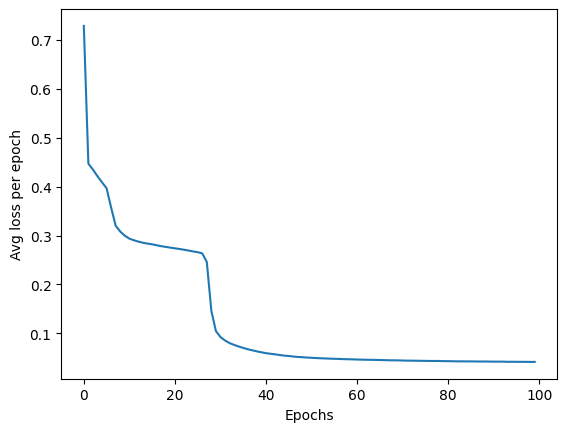

In [ ]:
plt.plot(loss_per_epoch)
plt.xlabel('Epochs')
plt.ylabel('Avg loss per epoch')
plt.show()

### 5) Testing the model
Finally, the model has to be tested in the testing set (data that was not seen during the training phase):

In [ ]:
net.eval() # Set model inot evaluation mode
with torch.no_grad(): # Only build forwards graph => faster method
    y_test_pred = net(x_test)

In [ ]:
loss_test = loss_func(y_test, y_test_pred)

print('Loss on testing set:', loss_test)

Loss on testing set: tensor(0.0405)


In [ ]:
import os
os.chdir('/content/drive/MyDrive/ML S&C PracticalAssignment1')


### 6) Visualizing predictions

In [ ]:
from parameters import h, v, u

h = h
v = v
u = u

params = [h, v, u]

We run the dynamics for $H$ steps using the true dynamics (blue points) and the predictions coming from our trained NN (red points) for a prespecified initial point $x_0$. Note that we plot only the first two components of the state vectors, which correspond to the car position $(x_{t}^{(1)}, x_{t}^{(2)}) = (x,y)$ on the $\mathbb{R}^2$ plane.

In [ ]:
import utils

def plotActualDynamicsAndNNPredictions(initial_state):

    state_actual = initial_state
    plt.scatter(state_actual[0][0], state_actual[0][1], color = 'blue')
    plt.text(state_actual[0][0] + 0.1, state_actual[0][1], '1', fontsize=10, color='blue', weight='bold') # add time step marker

    state_nn = torch.Tensor(initial_state)

    for t in range(10):

        #True dynamics
        state_actual = utils.systemDynamics(state_actual, params)
        plt.scatter(state_actual[0][0], state_actual[0][1], color = 'blue')
        plt.text(state_actual[0][0] + 0.1, state_actual[0][1], t+2, fontsize=10, color='blue', weight='bold') # add time step marker

        #NN dynamics
        with torch.no_grad():
            state_nn = net(state_nn)

        plt.scatter(state_nn[0][0], state_nn[0][1], color = 'red')
        plt.text(state_nn[0][0] + 0.1, state_nn[0][1], t+2, fontsize=10, color='red', weight='bold') # add time step marker


    plt.text(0, -0.15, 'Actual dynamics', fontsize=10, color='blue', weight='bold', transform=plt.gca().transAxes) #add legend
    plt.text(0, -0.2, 'NN prediction', fontsize=10, color='red', weight='bold', transform=plt.gca().transAxes) #add legend

#### 6.1) For $x_0 = [1.0, 1.0, 0.5]$

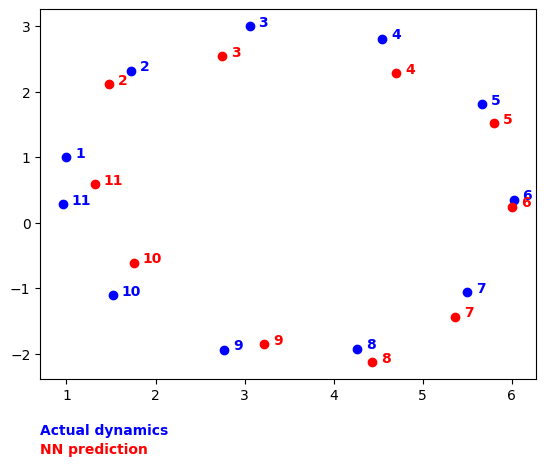

In [ ]:
initial_state = np.array([[1.0, 1.0, 0.5]])
plotActualDynamicsAndNNPredictions(initial_state)

#### 6.2) For $x_0 = [5.0, 8.0, 1.5]$

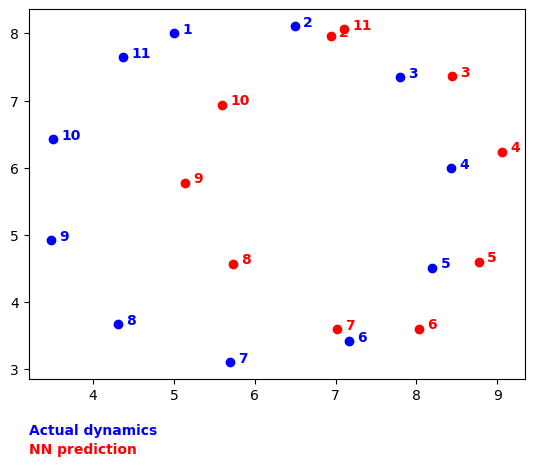

In [ ]:
initial_state = np.array([[5.0, 8.0, 1.5]])
plotActualDynamicsAndNNPredictions(initial_state)

### 7) Building a larger and more accurate NN

After seeing the previous example, we now have the goal of building <ins>a larger and more accurate NN.</ins> For this, we propose the changes below (but feel free to test other possibilities). Also, we ask a few more questions to guide your understanding of the training.

**NN structure**:

- <ins>Add one or two new hidden layers, varying the number of neurons per hidden layer.</ins> OBS: There are some discussions on the literature about *depth vs width* of neural networks.

- Test other types of <ins>activation functions (other than ReLU).

**Training parameters**:

- Increase the number of <ins>epochs; change the batch size</ins>

- Test other types of <ins>optimizers</ins> (e.g. RMSprop, Adagrad, ...)

- <ins>Add regularization to the loss function</ins> (e.g. L1, L2, Drpoout, Early stopping)



In [9]:
#ADD CODE HERE FOR SECTION 7

import torch
import torch.nn as nn
import torch.nn.functional as F

class Neural_network(nn.Module):
    def __init__(self):
        super(Neural_network, self).__init__()
        self.fc1 = nn.Linear(3, 7, bias=True)
        self.fc2 = nn.Linear(7, 10, bias=True)
        self.fc3 = nn.Linear(10, 3, bias=True)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


In [10]:
torch.manual_seed(0) # set random seed for variabl initialization

net = Neural_network() # initialize the NN
print(net)
print('')

params = list(net.parameters())
print('Number of parameter arrays: ' + str(len(params)))
print('The shape of the parameter arrays:')

for param in params:
    print(param.shape)

Neural_network(
  (fc1): Linear(in_features=3, out_features=7, bias=True)
  (fc2): Linear(in_features=7, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)

Number of parameter arrays: 6
The shape of the parameter arrays:
torch.Size([7, 3])
torch.Size([7])
torch.Size([10, 7])
torch.Size([10])
torch.Size([3, 10])
torch.Size([3])


In [11]:
loss_func = nn.MSELoss()

In [12]:
optimizer = optim.NAdam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [ ]:

# epochs = 100
# batch_size = 16

epochs = 150
batch_size = 15
batches = int(np.floor(len(y_train) / batch_size))

net.train()
Index = np.arange(len(y_train))
np.random.seed(0)

loss_per_epoch1 = []

lambda_reg = 0.001  # Regularization strength

for epoch in range(1, epochs + 1):
    np.random.shuffle(Index)
    loss_epoch = 0

    for batch in range(batches):
        Index_batch = Index[batch * batch_size:(batch + 1) * batch_size]
        x_batch = torch.tensor(x_train[Index_batch], dtype=torch.float32)  # Convert to PyTorch tensor
        y_batch = torch.tensor(y_train[Index_batch], dtype=torch.float32)  # Convert to PyTorch tensor

        optimizer.zero_grad()
        y_batch_pred = net(x_batch)

        # # Add dropout after the first fully connected layer
        # dropout = nn.Dropout(p=0.5)
        # x_batch = dropout(x_batch)

        loss = loss_func(y_batch_pred, y_batch)

        # Add L2 regularization to the loss
        l2_regularization = 0.0
        for param in net.parameters():
            l2_regularization += torch.norm(param, p=2)**2
        loss += lambda_reg * l2_regularization


        # # Add L1 regularization to the loss
        # l1_regularization = 0.0
        # for param1 in net.parameters():
        #     l1_regularization += torch.norm(param1, p=1)
        # loss += lambda_reg * l1_regularization


        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()

    loss_epoch /= batches
    loss_per_epoch1.append(loss_epoch)
    # print(f'Loss for epoch {epoch}/{epochs}: {loss_epoch:.4e}')




<ipython-input-18-5b73150066ad>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch = torch.tensor(x_train[Index_batch], dtype=torch.float32)  # Convert to PyTorch tensor
<ipython-input-18-5b73150066ad>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_train[Index_batch], dtype=torch.float32)  # Convert to PyTorch tensor


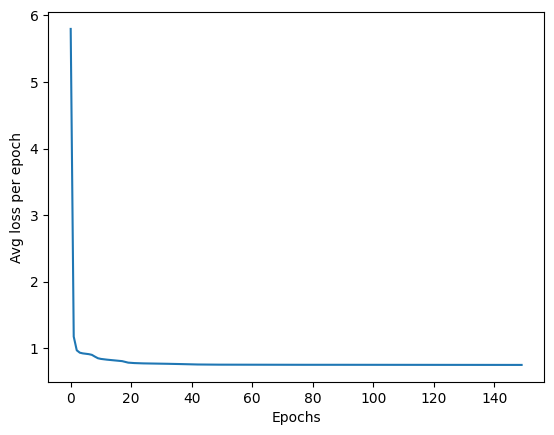

In [14]:
plt.plot(loss_per_epoch1)
plt.xlabel('Epochs')
plt.ylabel('Avg loss per epoch')
plt.show()

In [16]:
net.eval() # Set model inot evaluation mode
with torch.no_grad(): # Only build forwards graph => faster method
    y_test_pred = net(x_test)

In [17]:
loss_test = loss_func(y_test, y_test_pred)

print('Loss on testing set:', loss_test)
# 0.1672

Loss on testing set: tensor(0.2379)


In [ ]:
from parameters import h, v, u

h = h
v = v
u = u

params = [h, v, u]

In [ ]:
import utils

def plotActualDynamicsAndNNPredictions(initial_state):

    state_actual = initial_state
    plt.scatter(state_actual[0][0], state_actual[0][1], color = 'blue')
    plt.text(state_actual[0][0] + 0.1, state_actual[0][1], '1', fontsize=10, color='blue', weight='bold') # add time step marker

    state_nn = torch.Tensor(initial_state)

    for t in range(10):

        #True dynamics
        state_actual = utils.systemDynamics(state_actual, params)
        plt.scatter(state_actual[0][0], state_actual[0][1], color = 'blue')
        plt.text(state_actual[0][0] + 0.1, state_actual[0][1], t+2, fontsize=10, color='blue', weight='bold') # add time step marker

        #NN dynamics
        with torch.no_grad():
            state_nn = net(state_nn)

        plt.scatter(state_nn[0][0], state_nn[0][1], color = 'red')
        plt.text(state_nn[0][0] + 0.1, state_nn[0][1], t+2, fontsize=10, color='red', weight='bold') # add time step marker


    plt.text(0, -0.15, 'Actual dynamics', fontsize=10, color='blue', weight='bold', transform=plt.gca().transAxes) #add legend
    plt.text(0, -0.2, 'NN prediction', fontsize=10, color='red', weight='bold', transform=plt.gca().transAxes) #add legend


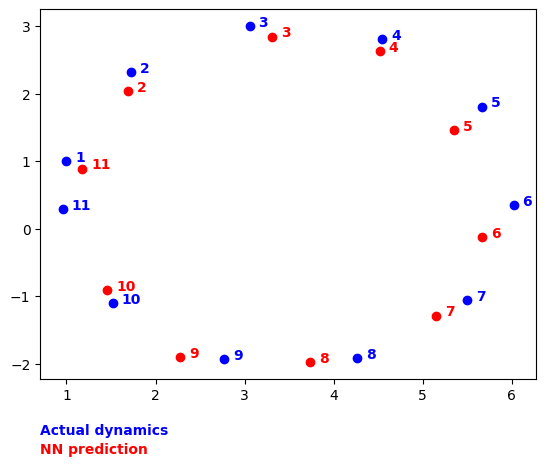

In [ ]:
initial_state = np.array([[1.0, 1.0, 0.5]])
plotActualDynamicsAndNNPredictions(initial_state)


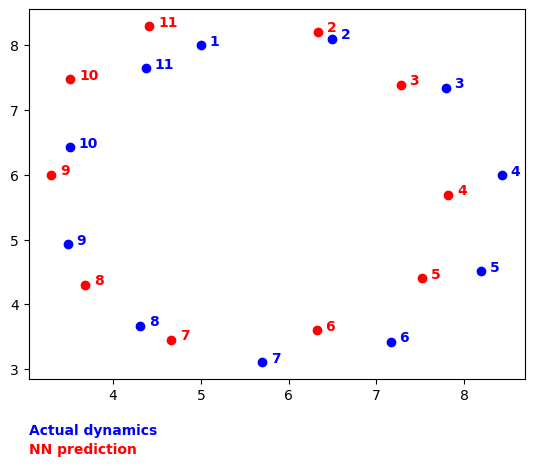

In [ ]:
initial_state = np.array([[5.0, 8.0, 1.5]])
plotActualDynamicsAndNNPredictions(initial_state)